# Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/train.csv', index_col='row_id')

In [3]:
example = train.loc['XX9B1M32E548Z42HB']

# Setup

We are going to use polar coordinates. These are defined by a radius _r_ and an angle _theta_:

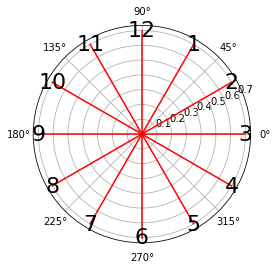

In [4]:
fig, ax = plt.subplots(
        figsize=(4,4), 
        subplot_kw={'projection': 'polar'}
        )
ax.set_rmax(1)

for i in range(1,13):
    theta = np.pi / 2 - i*np.deg2rad(360/12)
    r = 0.7
    plt.plot([theta,0], [r, 0], color='red')

    ax.text(
    theta, r, str(i), 
    ha='center', 
    va='center', 
    fontsize=22
    )

plt.show()

Now let's try to take the image closer to the data

# Digits

For digits, we need to define two things: position and relative size.

## Position

We don't have exact digit positions in the data, but using `{i} dist from cen` (distance from the centre) and `euc_dist_digit_{i}` (i.e. distance from a corresponding red line above) we can find the angle between the actual digit position and the red line from the right-angle triangle formed by all these lines. Hence we still don't know whether the angle is clockwise or counterclockwise, we'll assume it's always ccw

In [5]:
def digit_coordinates(i, example):
    dist_from_centre = example[f'{i} dist from cen']
    if not dist_from_centre:
        return None, None
    
    # calculate the angle
    sin_angle_deviation = example[f'euc_dist_digit_{i}'] / dist_from_centre
    # convert to radians and add to the "correct" digit position
    theta = np.pi / 2 - i*np.deg2rad(360/12) + np.arcsin(sin_angle_deviation)
    return theta, dist_from_centre

In [6]:
# we plot on a grid with radius of 1 and input images are 1024x1024 so we scale everything by 512
scale_coef = 512 
fontsize = 22

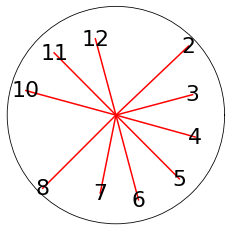

In [7]:
fig, ax = plt.subplots(
        figsize=(4,4), 
        subplot_kw={'projection': 'polar'}
        )

ax.set_rmax(1)

# generate blank canvas
ax.set_rticks([])
ax.set_thetagrids([])
ax.grid(False)
# ax.spines['polar'].set_visible(False)

# plot digits
for i in range(1, 13):
    theta, d = digit_coordinates(i, example)
    fontsize = 22
    if not pd.isna(d):
        r = d / scale_coef
        plt.plot([theta,0], [r, 0], color='red')
        ax.text(
            theta, r, str(i), 
            ha='center', 
            va='center', 
            fontsize=fontsize
            )

plt.show()

## Size

We have height and width of the digits. We will use width to scale the fontsize and ignore height, for simplicity

In [8]:
font_scale = 270 / 2 # figure size (4,4) produces ~270x270 images 
# so we another scaler to match pixel font size

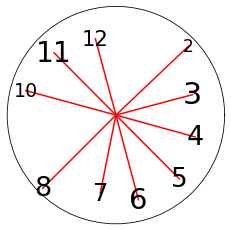

In [9]:
fig, ax = plt.subplots(
        figsize=(4,4), 
        subplot_kw={'projection': 'polar'}
        )

ax.set_rmax(1)

# generate blank canvas
ax.set_rticks([])
ax.set_thetagrids([])
ax.grid(False)
# ax.spines['polar'].set_visible(False)

# plot digits
for i in range(1, 13):
    theta, d = digit_coordinates(i, example)
    if not pd.isna(d):
        r = d / scale_coef
        plt.plot([theta,0], [r, 0], color='red')
        
        try:
            width = example[f'width_digit_{i}'] / scale_coef
            fontsize = round(width * font_scale)
        except ValueError:
            pass

        ax.text(
            theta, r, str(i), 
            ha='center', 
            va='center', 
            fontsize=fontsize
            )

plt.show()

# Hands

For hands we will use `minute_pointing_digit` and `hour_pointing_digit` since we already know the digit coordinates, and we have lengths in the data

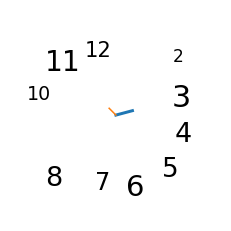

In [10]:
fig, ax = plt.subplots(
        figsize=(4,4), 
        subplot_kw={'projection': 'polar'}
        )

ax.set_rmax(1)

# generate blank canvas
ax.set_rticks([])
ax.set_thetagrids([])
ax.grid(False)
ax.spines['polar'].set_visible(False)
ax.autoscale(False)

# plot digits
for i in range(1, 13):
    theta, d = digit_coordinates(i, example)
    if not pd.isna(d):
        r = d / scale_coef
        
        width = example[f'width_digit_{i}'] / scale_coef
        fontsize = round(width * font_scale)

        ax.text(
            theta, r, str(i), 
            ha='center', 
            va='center', 
            fontsize=fontsize
            )
        
        if example['minute_pointing_digit'] == i:
            m = example['minute_hand_length'] / scale_coef
            plt.plot([theta,0], [m, 0], linewidth=3)

        if example['hour_pointing_digit'] == i:
            m = example['hour_hand_length'] / scale_coef
            plt.plot([0,theta], [0, m])
plt.show()

Almost done! We can make hands position a bit more realistic using `deviation_from_centre` - how far the implied centre is from (0,0) and `intersection_pos_rel_centre` to pick the right quadrant (we'll assume the point is always the middle of it). See complete code below.

# Putting it all together

In [11]:
centre_theta_dict = {
    'BR': np.pi/4,
    'BL': 3*np.pi/4,
    'TL': 5*np.pi/4,
    'TR': 7*np.pi/4,
}

def draw_a_clock(example, ax):
    ax.set_rmax(1)

    # generate blank canvas
    ax.set_rticks([])
    ax.set_thetagrids([])
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.autoscale(False)

    try:
        centre_r = example['deviation_from_centre'] / scale_coef
        centre_theta = centre_theta_dict[example['intersection_pos_rel_centre']]
    except (ValueError, KeyError):
        centre_r, centre_theta = 0, 0
    
    
    # plot digits
    for i in range(1, 13):
        theta, d = digit_coordinates(i, example)
        if not pd.isna(d):
            r = d / scale_coef

            width = example[f'width_digit_{i}'] / scale_coef
            fontsize = round(width * font_scale)

            ax.text(
                theta, r, str(i), 
                ha='center', 
                va='center', 
                fontsize=fontsize
                )

            if example['minute_pointing_digit'] == i:
                m = example['minute_hand_length'] / scale_coef
                ax.plot([theta,centre_theta], [m, centre_r], linewidth=2)

            if example['hour_pointing_digit'] == i:
                m = example['hour_hand_length'] / scale_coef
                ax.plot([centre_theta,theta], [centre_r, m], linewidth=3)
    ax.set_title(f"{example['diagnosis'].replace('_', '-').capitalize()}", va='top', ha='center')

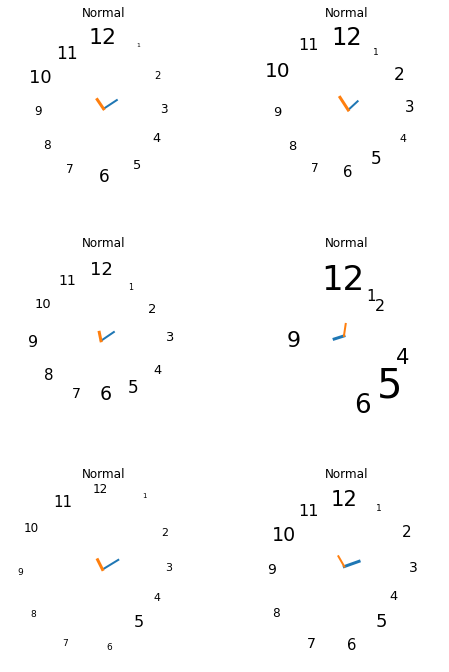

In [12]:
row, col = 3, 2

c = 'normal'

fig, axes = plt.subplots(row, col,
        figsize=(4*col,4*row), 
        subplot_kw={'projection': 'polar'}
        )

for ax in axes.reshape(-1):
    example = train[train['diagnosis'] == c].sample(1).iloc[0]
    draw_a_clock(example, ax)

plt.show()

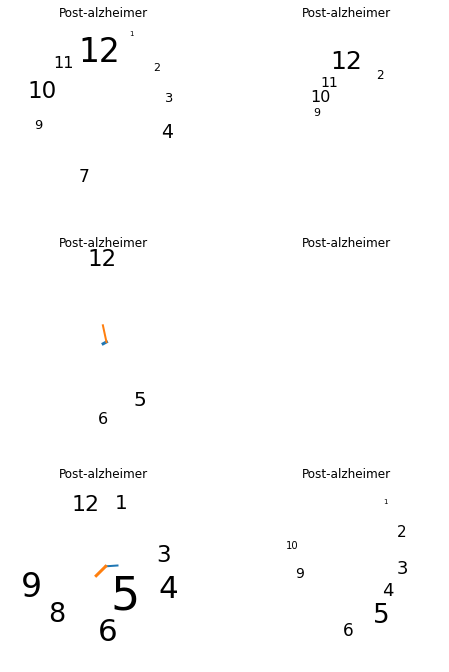

In [13]:
row, col = 3, 2

c = 'post_alzheimer'

fig, axes = plt.subplots(row, col,
        figsize=(4*col,4*row), 
        subplot_kw={'projection': 'polar'}
        )

for ax in axes.reshape(-1):
    example = train[train['diagnosis'] == c].sample(1).iloc[0]
    draw_a_clock(example, ax)

plt.show()

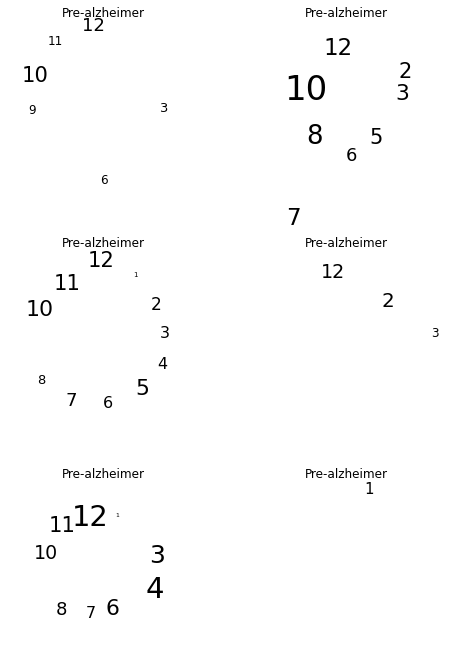

In [14]:
row, col = 3, 2

c = 'pre_alzheimer'

fig, axes = plt.subplots(row, col,
        figsize=(4*col,4*row), 
        subplot_kw={'projection': 'polar'}
        )

for ax in axes.reshape(-1):
    example = train[train['diagnosis'] == c].sample(1).iloc[0]
    draw_a_clock(example, ax)

plt.show()